https://qard.is.tohoku.ac.jp/T-Wave/?p=1136

In [7]:
!conda install -y attrdict tqdm

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/Braket

  added / updated specs:
    - attrdict
    - tqdm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    tqdm-4.53.0                |     pyhd8ed1ab_1          54 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          54 KB

The following NEW packages will be INSTALLED:

  tqdm               conda-forge/noarch::tqdm-4.53.0-pyhd8ed1ab_1



tqdm-4.53.0          | 54 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [13]:
from tqdm import tqdm
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pickle

import pyqubo

In [2]:
def load_data(path):
    with open(path, 'rb') as i_:
        return pickle.load(i_)

data = load_data('../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_4_30.pkl')

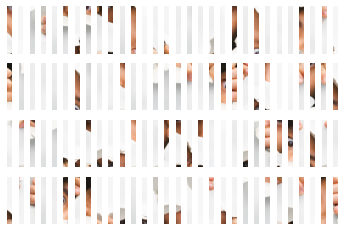

In [3]:
def show(images, rows, cols):
    fig = plt.figure()
    for i, image in enumerate(images):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.axis('off')
        ax.imshow(image)
    fig.show()

show(data.images, data.rows, data.cols)

In [4]:
def sim_x(left, right):
    shape = np.min((left.shape, right.shape), axis=0)
    return int((left[:shape[0], -1] == right[:shape[0], 0]).sum()*10/shape[0])

def sim_y(up, down):
    shape = np.min((up.shape, down.shape), axis=0)
    return int((up[-1, :shape[1]] == down[0, :shape[1]]).sum()*10/shape[1])


print(sim_x(data.images[0], data.images[1]))
print(sim_y(data.images[0], data.images[1]))

0
0


In [ ]:
def build_model(data, c=1):
    x = pyqubo.Array.create('x', shape=(data.size, data.rows, data.cols), vartype='BINARY')

    cost = 0
    sim = np.zeros((2, data.size, data.size))
    for a in tqdm(range(data.size)):
        for b in range(data.size):
            if a == b:
                continue
            for row in range(data.rows):
                for col in range(data.cols):
                    if row < data.rows - 1:
                        s = sim_y(data.images[a], data.images[b])
                        if s != 0:
                            cost -= s*x[a, row, col]*x[b, row + 1, col]
                            sim[0, a, b] = s
                    if col < data.cols - 1:
                        s = sim_x(data.images[a], data.images[b])
                        if s != 0:
                            cost -= s*x[a, row, col]*x[b, row, col + 1]
                            sim[1, a, b] = s

    constraint_coeff = c*(sim[0].max() + sim[1].max())
    for a in range(data.size):
        cost += constraint_coeff*pyqubo.Constraint((np.sum(x[a]) - 1)**2, f'img_{a}')
    for row in range(data.rows):
        for col in range(data.cols):
            cost += constraint_coeff*pyqubo.Constraint((np.sum(x[:, row, col]) - 1)**2, f'pos_{row}_{col}')

    return cost.compile(), x

model, x = build_model(data)

100%|██████████| 120/120 [19:56<00:00,  9.97s/it]


In [ ]:
bqm = model.to_bqm()

In [43]:
import neal

sampler = neal.SimulatedAnnealingSampler()
%time sampleset = sampler.sample(bqm, num_reads=1000)
decoded_samples = model.decode_sampleset(sampleset)
best_sample = min(decoded_samples, key=lambda x: x.energy)

CPU times: user 14.5 s, sys: 8.07 ms, total: 14.5 s
Wall time: 14.5 s


cost: -165.0


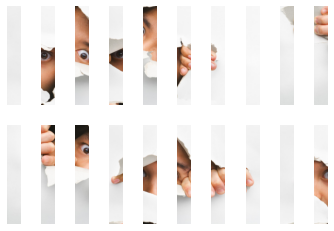

In [44]:
def is_feasible(sample):
    return all(v[0] for v in sample.constraints().values())

def show_solution(sample, data, x):
    values = np.vectorize(lambda x: sample[x.label])(x)
    pos = np.array(np.where(values == 1)).T
    images = [
        data.images[p[0]]
        for p in sorted(pos, key=lambda x: [x[1], x[2]])
    ]
    show(images[:data.size], data.rows, data.cols)

assert is_feasible(best_sample)
print(f'cost: {best_sample.energy}')
show_solution(best_sample.sample, data, x)

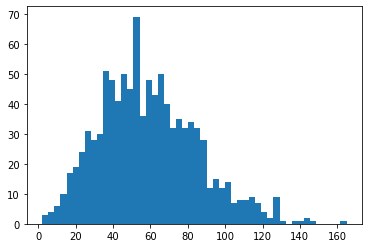

In [45]:
import matplotlib.pyplot as plt

_ = plt.hist([-sample.energy for sample in decoded_samples], bins=50)

## D-Wave Hybrid への投入

In [ ]:
import boto3
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler
from dwave.system.composites import EmbeddingComposite
import hybrid

aws_account_id = boto3.client("sts").get_caller_identity()["Account"]
bucket = "amazon-braket-ohtaman"
prefix = "d-wave/output"
s3_location = (bucket, prefix)

In [ ]:
# device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6")
device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/Advantage_system1")
print('Device:', device)

In [ ]:
sampler = BraketDWaveSampler(s3_location, device.arn)
sampler = EmbeddingComposite(sampler)

In [ ]:
%time

# Define the workflow
iteration = hybrid.RacingBranches(
    hybrid.InterruptableTabuSampler(),
    hybrid.EnergyImpactDecomposer(size=2)
    | hybrid.QPUSubproblemAutoEmbeddingSampler(qpu_sampler=sampler)
    | hybrid.SplatComposer()
) | hybrid.ArgMin()
workflow = hybrid.LoopUntilNoImprovement(iteration, convergence=3)

# Solve the problem
init_state = hybrid.State.from_problem(bqm)
final_state = workflow.run(init_state).result()

# Print results
#print("Solution: sample={.samples.first}".format(final_state))

In [ ]:
decoded_samples = model.decode_sampleset(final_state.samples)
best_sample = min(decoded_samples, key=lambda x: x.energy)

In [ ]:
# assert is_feasible(best_sample)
print(f'is feasible: {is_feasible(best_sample)}')
print(f'cost: {best_sample.energy}')
show_solution(best_sample.sample, data, x)

In [ ]:
_ = plt.hist([-sample.energy for sample in decoded_samples], bins=50)